# REST-API example impactu

In [658]:
import pandas as pd
import requests
import json
from IPython.display import JSON
from unidecode import unidecode
def flatten(xss):
    return [x for xs in xss for x in xs]

Obtain "Uiversidad de Antioquia" works

In [1]:
import pandas as pd
import requests
#%%time
DJ = []
total = 105018 
#total = 965
page_ini = 1
max_page = 250
extra_page = 0
if total%max_page != 0:
    extra_page = 1
page_end = total//max_page + extra_page
for p in range(page_ini,page_end+1):
    url = f'https://api.impactu.colav.co/affiliation/institution/03bp5hc83/research/products?max={max_page}&page={p}'
    #url = f'https://api.impactu.colav.co/search/works?max={max_page}&page={p}&status=diamond&subjects=1_Library+science'
    dj = requests.get(url)
    if dj.status_code == 200:
        print(p,end="\r")
        jl = dj.json()['data']
        for d in jl:
            kk = d.pop('abstracts')
        i = 0
        for d in jl:
            if len(jl[i]['authors']) > 10:
                kk = jl.pop(i)
            else:
                i += 1        

        
        DJ = DJ +  jl

In [7]:
len(DJ)

102165

save the list to a JSON file

In [5]:
f = open('udea.json','w')
json.dump(DJ,f)
f.close()

In [6]:
ls -lh udea.json

-rw-r--r-- 1 restrepo restrepo 860M Feb 13 13:30 udea.json


In [34]:
f = open('udea.json','r')
DJ = json.load(f)
f.close()

## Anlysis in pandas

In [649]:
df = pd.DataFrame(DJ)

In [650]:
df.shape

(102165, 23)

In [651]:
df = df[df['external_ids'].apply(lambda L: any([True for d in L if d.get('provenance') == 'scienti' and d.get('source') == 'scienti']))].reset_index(drop=True)

In [652]:
df.shape

(80052, 23)

search authors

In [601]:
full_name = 'diego alejandro restrepo quintero'
#full_name = 'carlos alberto duque echeverri'
dfa = df[df.authors.apply(lambda L: any([True for d in L if unidecode(str(d.get('full_name')).lower()) == full_name ]))]

Check the json:

In [646]:
#JSON(dfa.authors.iloc[0])

De conformidad  con lo dispuesto en el Acuerdo Superior 083 del 22 de julio de 1996 (Estatuto profesoral) la carrera docente de la institución se compone  de las categorías de profesor auxiliar, profesor asistente, profesor asociado y profesor titular. 

In [604]:
#JSON(df.authors.iloc[80049])

remove not scienti authors...

In [653]:
df['scienti_authors'] = df.authors.apply(lambda L: [
                          {'COD_RH':d.get('external_ids')[0].get('id'),
                           'last_names':d.get('last_names'),
                           'first_names':d.get('first_names'),
                           'sex':d.get('sex').lower(),
                           'age':d.get('age'),
                           'affiliations': [{'name': dd.get('name'),
                                             'id': dd.get('id'),
                                             'type': dd.get('types')[0].get('type')
                                            } for dd in d.get('affiliations')],
                           'ranking': [dd for dd in d.get('ranking') if dd.get('source') == 'categoría_laboral' ]
                          } for d in L 
                            if d.get('sex') and 
                            any([True for dd in d.get('external_ids') 
                                 if dd.get('provenance') == 'scienti' and dd.get('source') == 'scienti'])   ])

In [ ]:
L = df['scienti_authors'].to_list()

L = flatten(L)

dfL = pd.DataFrame(L)

del L

dfL.shape

In [618]:
udea = dfL[dfL['affiliations'].apply(lambda L: [d.get('name') for d in L 
         if d.get('type') == 'Education' and d.get('name') == 'Universidad de Antioquia']).apply(len)>0
         ].reset_index(drop=True)

In [619]:
udea['affiliations'].apply(lambda L: [d.get('name') for d in L 
         if d.get('type') == 'Education']).iloc[0]

['Universidad de Antioquia', 'Universidad de Pamplona']

In [620]:
udea.affiliations.iloc[0]

[{'name': 'Universidad de Antioquia', 'id': '03bp5hc83', 'type': 'Education'},
 {'name': 'Instituto de Biología',
  'id': '03bp5hc83_3_21420003_3513',
  'type': 'department'},
 {'name': 'Facultad de Ciencias Exactas y Naturales',
  'id': '03bp5hc83_3',
  'type': 'faculty'},
 {'name': 'Gebiomic (genética y Bioquímica de Microorganismos)',
  'id': 'COL0014064',
  'type': 'group'},
 {'name': 'Corporación para Investigaciones Biológicas',
  'id': '03evkbw14',
  'type': 'Facility'},
 {'name': 'Universidad de Pamplona', 'id': '04dfr7a85', 'type': 'Education'},
 {'name': 'Genética, Regeneración y Cáncer',
  'id': 'COL0006769',
  'type': 'group'}]

In [621]:
udea['faculty'] = udea['affiliations'].apply(lambda L: [d.get('name') for d in L 
         if d.get('type') == 'faculty' and d.get('id').find(ror) > -1  ]).apply(lambda L: L  if len(L) > 0 else 
                                                ['unknown']).str[0]
udea['department'] = udea['affiliations'].apply(lambda L: [d.get('name') for d in L 
         if d.get('type') == 'department' and d.get('id').find(ror) > -1 ]).apply(lambda L: L  if len(L) > 0 else 
                                                ['unknown']).str[0]
udea['group'] = udea['affiliations'].apply(lambda L: [d.get('name') for d in L 
         if d.get('type') == 'group' ]).apply(lambda L: L  if len(L) > 0 else 
                                                ['unknown']).str[0]

In [622]:
udea.shape

(103897, 10)

In [623]:
udea.drop_duplicates(subset=['COD_RH','sex','age','faculty','department','group']).shape

(4579, 10)

In [624]:
udea.drop_duplicates(subset=['COD_RH']).shape

(4579, 10)

In [625]:
udea = udea.drop_duplicates(subset=['COD_RH']).reset_index(drop=True)

In [626]:
fm = udea['sex'].value_counts()
print(f"{round(fm['mujer']/(fm['mujer']+fm['hombre'])*100,1)} % of {fm['mujer']+fm['hombre']}")

45.9 % of 4577


In [627]:
fm = udea['sex'].value_counts()
print(f"UdeA: {round(fm['mujer']/(fm['mujer']+fm['hombre'])*100,1)} % of {fm['mujer']+fm['hombre']}")
for f in udea.faculty.unique() :
    udea_f = udea[udea['faculty'] == f]
    fm = udea_f['sex'].value_counts()
    if not fm.get('mujer'):
        fm['mujer'] = 0
    if not fm.get('hombre'):
        fm['hombre'] = 0        
    print(f"{f}: {round(fm['mujer']/(fm['mujer']+fm['hombre'])*100,1)} % of {fm['mujer']+fm['hombre']}")
    for ff in  udea_f.department.unique():
        udea_d = udea[ ((udea['faculty'] == f) & (udea['department'] == ff)) ]
        fm = udea_d['sex'].value_counts()
        if not fm.get('mujer'):
            fm['mujer'] = 0
        if not fm.get('hombre'):
            fm['hombre'] = 0        
        print(f"   {ff}: {round(fm['mujer']/(fm['mujer']+fm['hombre'])*100,1)} % of {fm['mujer']+fm['hombre']}")

    #if f == 'Escuela de Microbiología':
    #    break

UdeA: 45.9 % of 4577
Facultad de Ciencias Exactas y Naturales: 25.3 % of 292
   Instituto de Biología: 44.0 % of 75
   Instituto de Química: 26.2 % of 80
   Instituto de Física: 11.5 % of 78
   unknown: 33.3 % of 3
   Departamento de Matemáticas: 17.0 % of 53
   Programa Ingeniería Civil: 0.0 % of 1
   Programa Regionalización Urabá: 50.0 % of 2
Facultad de Medicina: 43.9 % of 478
   Departamento de Cirugía: 24.1 % of 58
   Departamento de Farmacología y Toxicología: 50.0 % of 22
   Departamento de Microbiología y Parasitología: 56.1 % of 57
   Departamento de Pediatría y Puericultura: 54.1 % of 74
   Departamento de Medicina Interna: 29.3 % of 75
   Instituto de Investigaciones Médicas: 46.2 % of 39
   Centro de Investigaciones Médicas: 50.0 % of 8
   Departamento de Fisiología: 40.7 % of 27
   Departamento de Siquiatría y Ciencias del Comportamiento Humano: 29.4 % of 17
   Departamento de Morfología: 33.3 % of 9
   Departamento de Bioquímica: 33.3 % of 3
   Departamento de Obstetrici

In [642]:
for r in [ 'AUXILIAR' , 'ASISTENTE','ASOCIADO','TITULAR']:
    fm = udea[udea['ranking'].apply(lambda L: r in [d.get('rank') for d in L])]['sex'].value_counts()
    print(f"{r}: {round(fm['mujer']/(fm['mujer']+fm['hombre'])*100,1)} % of {fm['mujer']+fm['hombre']}")

AUXILIAR: 46.5 % of 1287
ASISTENTE: 46.8 % of 1973
ASOCIADO: 43.0 % of 1185
TITULAR: 41.2 % of 808


In [643]:
f = 'Facultad de Ciencias Exactas y Naturales'
ff = 'Instituto de Física'
udea_f = udea[ ((udea['faculty'] == f)) ]
udea_d = udea[ ((udea['faculty'] == f) & (udea['department'] == ff)) ]

In [644]:
for r in [ 'AUXILIAR' , 'ASISTENTE','ASOCIADO','TITULAR']:
    fm = udea_f[udea_f['ranking'].apply(lambda L: r in [d.get('rank') for d in L])]['sex'].value_counts()
    print(f"{r}: {round(fm['mujer']/(fm['mujer']+fm['hombre'])*100,1)} % of {fm['mujer']+fm['hombre']}")

AUXILIAR: 25.5 % of 110
ASISTENTE: 26.6 % of 207
ASOCIADO: 21.4 % of 126
TITULAR: 20.0 % of 95


In [645]:
for r in [ 'AUXILIAR' , 'ASISTENTE','ASOCIADO','TITULAR']:
    fm = udea_d[udea_d['ranking'].apply(lambda L: r in [d.get('rank') for d in L])]['sex'].value_counts()
    print(f"{r}: {round(fm['mujer']/(fm['mujer']+fm['hombre'])*100,1)} % of {fm['mujer']+fm['hombre']}")

AUXILIAR: 12.0 % of 25
ASISTENTE: 11.1 % of 54
ASOCIADO: 3.1 % of 32
TITULAR: 3.6 % of 28


In [440]:
import matplotlib.pyplot as plt
import numpy as np

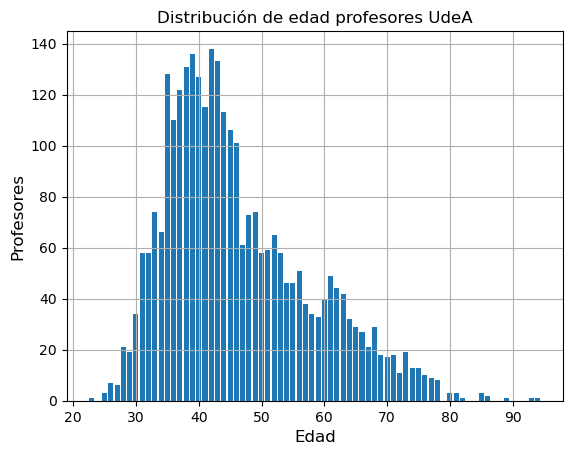

In [475]:
kk = udea['age'].sort_values().dropna().astype(int).value_counts()

age = pd.DataFrame()

age['age'] = kk.keys()

age['counts'] = kk.values

age = age.sort_values('age')

plt.bar(age['age'],age['counts'])
plt.xlabel('Edad', size = 12)
plt.ylabel('Profesores', size = 12)
plt.title('Distribución de edad profesores UdeA')
plt.grid()

In [483]:
f = 'Facultad de Ciencias Exactas y Naturales'
ff = 'Instituto de Física'
udea_f = udea[ ((udea['faculty'] == f)) ]
udea_d = udea[ ((udea['faculty'] == f) & (udea['department'] == ff)) ]

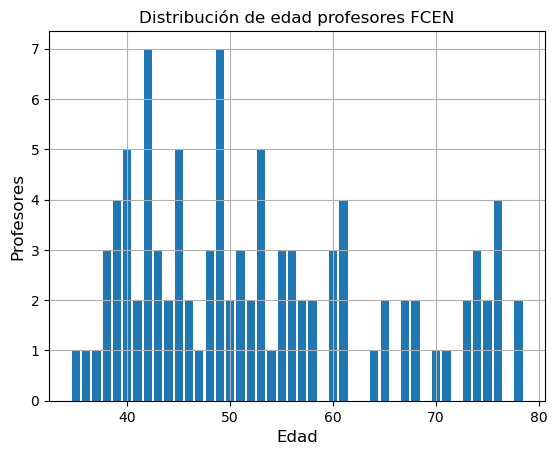

In [487]:
kk = udea_f['age'].sort_values().dropna().astype(int).value_counts()

age = pd.DataFrame()

age['age'] = kk.keys()

age['counts'] = kk.values

age = age.sort_values('age')

plt.bar(age['age'],age['counts'])
plt.xlabel('Edad', size = 12)
plt.ylabel('Profesores', size = 12)
plt.title('Distribución de edad profesores FCEN')
plt.grid()

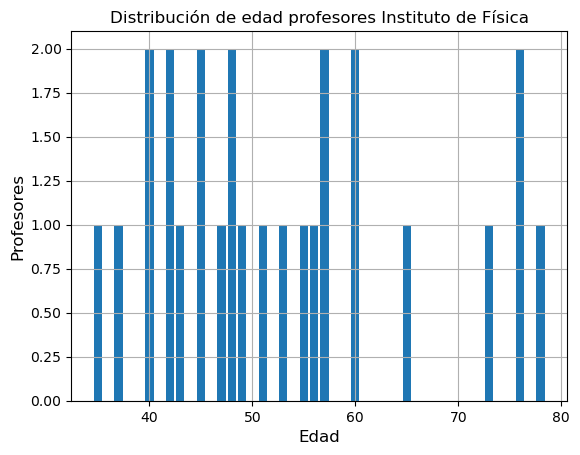

In [488]:
kk = udea_d['age'].sort_values().dropna().astype(int).value_counts()

age = pd.DataFrame()

age['age'] = kk.keys()

age['counts'] = kk.values

age = age.sort_values('age')

plt.bar(age['age'],age['counts'])
plt.xlabel('Edad', size = 12)
plt.ylabel('Profesores', size = 12)
plt.title('Distribución de edad profesores Instituto de Física')
plt.grid()

In [738]:
y = 2020
dfy = df[df.year_published == y]

In [739]:
    L = dfy['scienti_authors'].to_list()
    L = flatten(L)

    dfL = pd.DataFrame(L)

In [741]:
dfL.shape

(6448, 7)

In [742]:
dfL.drop_duplicates('COD_RH').shape

(2299, 7)

In [838]:
FACULTY = False
DEPARTMENT = False
UDEA = pd.DataFrame()
w = []
for y in [y for y in set(df.year_published.fillna(0).astype(int)) if y > 0]:
    dfy = df[df.year_published == y]
    if dfy.empty:
        continue
    L = dfy['scienti_authors'].to_list()
    L = flatten(L)
    if not L:
        continue
    dfL = pd.DataFrame(L)
    del L

    # Filter pure UdeA authors
    udeay = dfL[dfL['affiliations'].apply(lambda L: [d.get('name') for d in L 
         if d.get('type') == 'Education' and d.get('name') == 'Universidad de Antioquia']).apply(len)>0
         ].reset_index(drop=True)   

    udeay['faculty'] = udeay['affiliations'].apply(lambda L: [d.get('name') for d in L 
         if d.get('type') == 'faculty' and d.get('id').find(ror) > -1  ]).apply(lambda L: L  if len(L) > 0 else 
                                                ['unknown']).str[0]
    udeay['department'] = udeay['affiliations'].apply(lambda L: [d.get('name') for d in L 
         if d.get('type') == 'department' and d.get('id').find(ror) > -1 ]).apply(lambda L: L  if len(L) > 0 else 
                                                ['unknown']).str[0]
    udeay['group'] = udeay['affiliations'].apply(lambda L: [d.get('name') for d in L 
         if d.get('type') == 'group' ]).apply(lambda L: L  if len(L) > 0 else 
                                                ['unknown']).str[0]    
    udeay = udeay.drop_duplicates(subset=['COD_RH']).reset_index(drop=True)

    udeay['year'] = y
    UDEA = pd.concat((UDEA,udeay)) 
    
    if FACULTY:
        f = 'Facultad de Ciencias Exactas y Naturales'
        udeay = udeay[ ((udeay['faculty'] == f)) ]
    if DEPARTMENT:       
        ff = 'Instituto de Física'
        udeay = udeay[ ((udeay['faculty'] == f) & (udeay['department'] == ff)) ]
    
    #.drop_duplicates(subset=['COD_RH']).reset_index(drop=True)

    d = {}
    d['year'] = y
    d['works'] = dfy.shape[0]
    d['hombre'] = udeay[udeay['sex'] == 'hombre'].shape[0]
    d['mujer'] = udeay[udeay['sex'] == 'mujer'].shape[0]
    d['authors'] = d['hombre'] + d['mujer']
    w.append(d)

Text(0, 0.5, 'works')

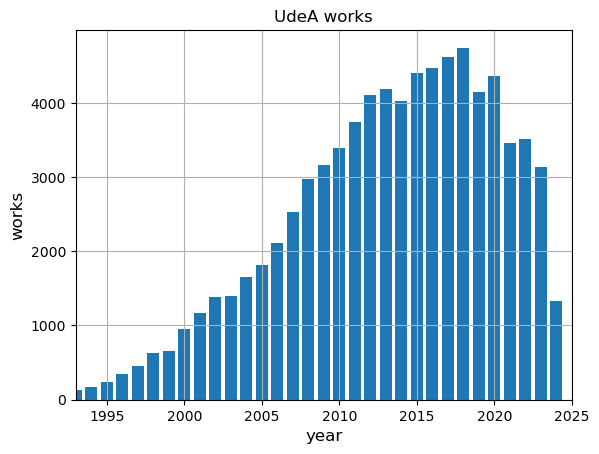

In [832]:
dw = pd.DataFrame(w).sort_values('year')
dw['f/m'] = round(dw['mujer']/dw['authors'],4)

plt.bar(dw['year'],dw['works'])
plt.xlim(1993,2025)
plt.grid()
plt.title('UdeA works')
plt.xlabel('year',size = 12)
plt.ylabel('works',size = 12)

Text(0, 0.5, 'professors')

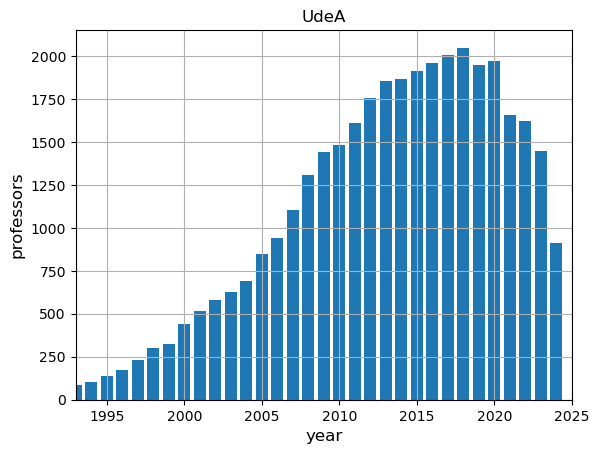

In [833]:
plt.bar(dw['year'],dw['authors'])
plt.xlim(1993,2025)
plt.grid()
plt.title('UdeA')
if FACULTY:
    plt.title(f)
if DEPARTMENT:
    plt.title(ff)

plt.xlabel('year',size = 12)
plt.ylabel('professors',size = 12)

Text(0, 0.5, 'female ratio')

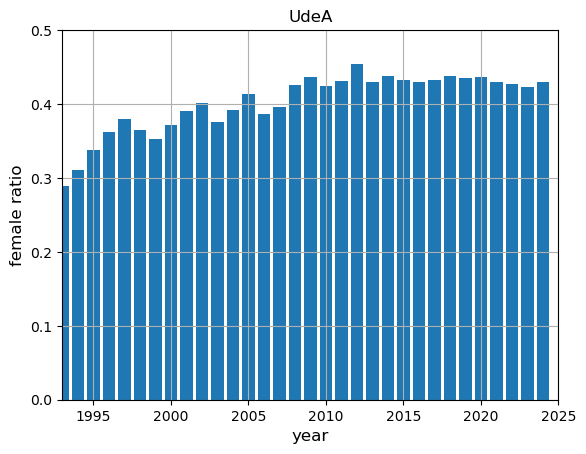

In [834]:
plt.bar(dw['year'],dw['f/m'])
plt.xlim(1993,2025)
plt.grid()
plt.ylim(0,0.5)
if DEPARTMENT:
    plt.xlim(2002,2025)
    plt.ylim(0,0.1)

plt.title('UdeA')
if FACULTY:
    plt.title(f)
if DEPARTMENT:
    plt.title(ff)

plt.xlabel('year',size = 12)
plt.ylabel('female ratio',size = 12)

In [843]:
UDEA['full_name']=UDEA.first_names.apply(' '.join)+' '+UDEA.last_names.apply(' '.join)

In [919]:
y1 = 2020
y2 = 2023
udea_diff = pd.DataFrame({'COD_RH' : list(set(UDEA[UDEA['year']==y1].COD_RH).difference(UDEA[UDEA['year']==y2].COD_RH))})

In [920]:
udea_diff = udea_diff.merge(UDEA.drop_duplicates('COD_RH')[['COD_RH','full_name','faculty','department']],
                on='COD_RH',how='left')

In [921]:
udea_diff.shape

(913, 4)

In [922]:
dw[-5:-3]

,year,works,hombre,mujer,authors,f/m
59,2020,4359,1111,861,1972,0.4366
60,2021,3453,944,710,1654,0.4293


In [923]:
print(f'Authors which publish in {y1} but not in {y2}:')
#print(f'in {f}')
#udea_diff[udea_diff['faculty'] == f].reset_index(drop=True)
print(f'in {ff}')
udea_diff[udea_diff['department'] == ff].reset_index(drop=True)

Authors which publish in 2020 but not in 2023:
in Instituto de Física


,COD_RH,full_name,faculty,department
0,0000000639,Gloria Eugenia Campillo Figueroa,Facultad de Ciencias Exactas y Naturales,Instituto de Física
1,0000348090,Alvaro Herrera Carrillo,Facultad de Ciencias Exactas y Naturales,Instituto de Física
2,0000167991,Jorge Hernan Lopez Botero,Facultad de Ciencias Exactas y Naturales,Instituto de Física
3,0000346780,William Antonio Ponce Gutierrez,Facultad de Ciencias Exactas y Naturales,Instituto de Física
4,0001581561,Viktor Tulupenko,Facultad de Ciencias Exactas y Naturales,Instituto de Física
5,0001405606,Sorayda Trejos Gonzalez,Facultad de Ciencias Exactas y Naturales,Instituto de Física
6,0000196878,Fabiola del Socorro Gomez Gomez,Facultad de Ciencias Exactas y Naturales,Instituto de Física
7,0000036897,Jorge Enrique Tobon Gomez,Facultad de Ciencias Exactas y Naturales,Instituto de Física
8,0000320714,German Ricaurte Avella,Facultad de Ciencias Exactas y Naturales,Instituto de Física
9,0000104647,Jaime Alberto Osorio Velez,Facultad de Ciencias Exactas y Naturales,Instituto de Física
